# Importation des librairies et des données

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset
import plotly
from plotly.offline import init_notebook_mode
import plotly.express as px
import scipy
from scipy import stats
import seaborn as sns
import sys
import sklearn
from sklearn import decomposition
from sklearn.metrics.cluster import adjusted_rand_score 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
data = pd.read_csv('df.csv')
customer = pd.read_csv('olist_customers_dataset.csv')
order = pd.read_csv('olist_orders_dataset.csv')

## Création du DataFrame 

In [3]:
last_purchase_date = customer.merge(order, on='customer_id')[['customer_unique_id', 'order_purchase_timestamp']].groupby('customer_unique_id').max().reset_index()

In [4]:
df = data.merge(last_purchase_date, on='customer_unique_id').drop(['customer_unique_id', 'days_of_waiting_2', 'geolocation_lat',
                                                             'geolocation_lng', 'boleto', 'credit_card', 'debit_card', 'voucher'], axis=1)

In [5]:
df

,review_score,days_of_waiting,freight_by_price,mean_item_per_order,distance_bet_cust_n_sell,last_purchase,number_orders,payment_total,order_purchase_timestamp
0,5.0,7.0,0.092379,1.0,1.030198,112,1,141.90,2018-05-10 10:56:27
1,4.0,4.0,0.438624,1.0,0.158790,115,1,27.19,2018-05-07 11:11:27
2,3.0,27.0,0.249565,1.0,4.746077,538,1,86.22,2017-03-10 21:05:03
3,4.0,21.0,0.678338,1.0,22.188119,322,1,43.62,2017-10-12 20:29:41
4,5.0,14.0,0.093833,1.0,1.512516,289,1,196.89,2017-11-14 19:45:42
...,...,...,...,...,...,...,...,...,...
91415,5.0,29.0,0.320939,2.0,18.240361,448,1,2067.42,2017-06-08 21:00:36
91416,4.0,31.0,0.303437,1.0,13.981994,263,1,84.58,2017-12-10 20:07:56
91417,5.0,16.0,0.250945,1.0,14.079531,569,1,112.46,2017-02-07 15:49:16
91418,5.0,13.0,0.162522,1.0,6.131714,120,1,133.69,2018-05-02 15:17:41


## Retypage de la date de la commande

In [6]:
df.order_purchase_timestamp = df.order_purchase_timestamp.apply(pd.to_datetime, format='%Y-%m-%d')

In [7]:
df.order_purchase_timestamp = df.order_purchase_timestamp.apply(lambda x: x.date())

# Initialisation avec un an de données

In [8]:
#Sélection des clients ayant commandés pour la dernière fois la première année
df0 = df[df.order_purchase_timestamp <= (df.order_purchase_timestamp.min() + DateOffset(years=1))]

C:\Users\moham\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.



In [9]:
#Suppression de order_purchase_timestamp
df0 = df0.drop("order_purchase_timestamp", axis = 1)

#standardisation
ss = StandardScaler()
df0_scaled = pd.DataFrame(data= ss.fit_transform(df0), columns = df0.columns)

#analyse en composantes principales pour réduction
pca0 = decomposition.PCA(random_state = 42)
pca0.fit(df0_scaled)
projected0 = pca0.transform(df0_scaled)

#on récupère les 3 eres composantes principales
df0_scaled["PC1"] =projected0[:,0]
df0_scaled["PC2"] = projected0[:,1]
df0_scaled["PC3"] = projected0[:,2]
    
df0_pca0 = df0_scaled[['PC1','PC2', 'PC3']]

# Fonctions

In [10]:
def calc_period(data, nbdays):
    '''
    Fonction qui crée un dataframe avec 1 an + nbdays de données
        Paramètre : 
            data : dataframe 
            nbdays : entier, nombre de jours à ajouter à 365 jours
        Sortie : Dataframe de données sur l'intervalle de temps voulu
        
    '''
    return data[data.order_purchase_timestamp <= (data.order_purchase_timestamp.min() + DateOffset(days=365+nbdays))]

In [11]:
def std_pca_data(df):
    '''
    Fonction qui standardise puis réalise une ACP et réduis à 3 composantes un Dataframe
        Paramètres : 
            df : Dataframe 
        Sortie : 
            Dataframe standardisé et projeté sur ses 3 premières composantes principales 
    '''
    df = df.drop("order_purchase_timestamp", axis = 1)
    #standardisation
    ss = StandardScaler()
    df_scaled = pd.DataFrame(data= ss.fit_transform(df), columns = df.columns)
    #analyse en composantes principales pour réduction
    pca = decomposition.PCA(random_state = 42)
    pca.fit(df_scaled)
    projected = pca.transform(df_scaled)
    #on récupère les 3 eres composantes principales
    df_projected = pd.DataFrame()
    df_projected["PC1"] =projected[:,0]
    df_projected["PC2"] = projected[:,1]
    df_projected["PC3"] = projected[:,2]
    
    #df_pca = df_scaled[['PC1','PC2', 'PC3']]
    
    return   df_projected, df_scaled   

In [12]:
def calcKmeans(df_pca): 
    '''
    Applique la segmentation K-means sur un dataframe
    
        Paramètres : 
            df_pca: dataframe (réduis avec ACP idéalement) à segmenter
        Sortie : 
            Liste des clusters calculés
    '''
    kmeans = KMeans(n_clusters = 5, random_state = 1).fit(df_pca)
    #clusters = kmeans.predict(df_pca)
    cluster_labels = kmeans.labels_
    df_pca_km = df_pca.assign(Cluster = cluster_labels)
    return  cluster_labels

# Evolution de l'ARI Score

In [13]:
ari_score = []
for i in range(0,300,20):
    
    df_projected_i, df_scaled_i = std_pca_data(calc_period(df, i))

    #On applique la PCA initiale sur la nouvelle période
    projected_i0 = pca0.transform(df_scaled_i)
    #on récupère les 3 eres composantes principales
    df_projected_i0 = pd.DataFrame()
    df_projected_i0["PC1"] =projected_i0[:,0]
    df_projected_i0["PC2"] = projected_i0[:,1]
    df_projected_i0["PC3"] = projected_i0[:,2]
    
    #df_pca_k0 = df_scaled_k[['PC1','PC2', 'PC3']]
    ari_i = adjusted_rand_score(calcKmeans(df_projected_i0),calcKmeans(df_projected_i))
    
    ari_score.append([i,ari_i])

C:\Users\moham\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

C:\Users\moham\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

C:\Users\moham\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

C:\Users\moham\anaconda3\lib\si

In [14]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"] )
ari_score

,periode,ARI
0,0,1.000000
1,20,0.871977
2,40,0.807871
3,60,0.898249
4,80,0.889262
5,100,0.468994
6,120,0.454022
7,140,0.424584
8,160,0.383975
9,180,0.400019


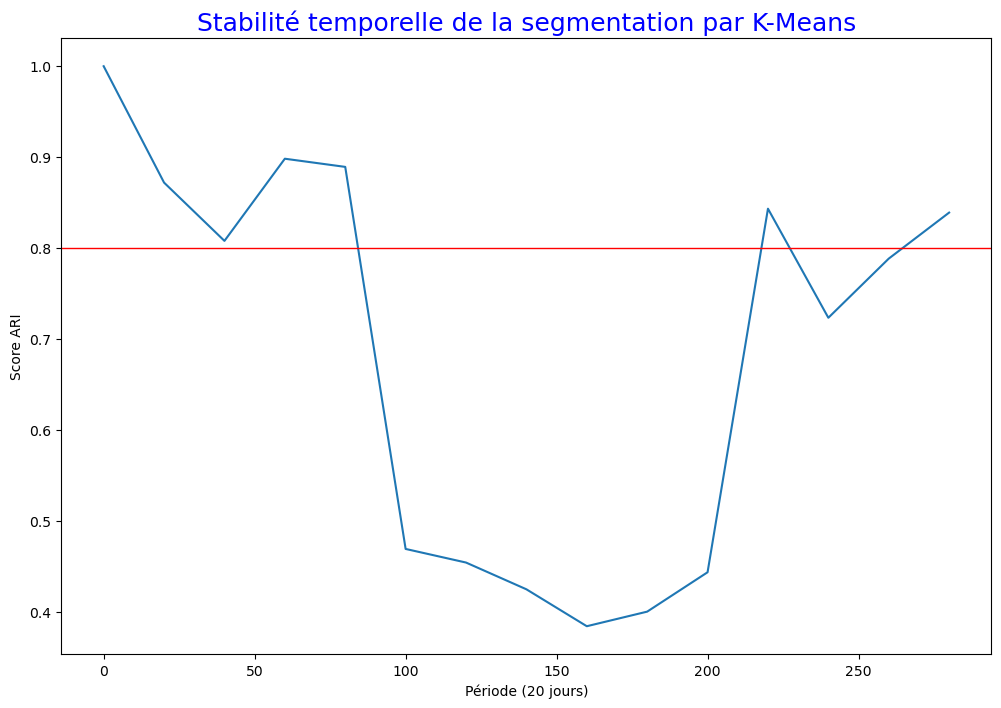

In [15]:
# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.axhline(y=0.80, c='r', linewidth=1)

plt.xlabel("Période (20 jours)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

On observe qu'entre 80 et 100 jours l'ARI Score décroit très brusquement. Par soucis de précision on décide de "zoomer" sur cette periode afin d'observer plus en détail.

In [16]:
ari_score = []
for i in range(80,100):
    
    df_projected_i, df_scaled_i = std_pca_data(calc_period(df, i))

    #On applique la PCA initiale sur la nouvelle période
    projected_i0 = pca0.transform(df_scaled_i)
    #on récupère les 3 eres composantes principales
    df_projected_i0 = pd.DataFrame()
    df_projected_i0["PC1"] =projected_i0[:,0]
    df_projected_i0["PC2"] = projected_i0[:,1]
    df_projected_i0["PC3"] = projected_i0[:,2]
    
    #df_pca_k0 = df_scaled_k[['PC1','PC2', 'PC3']]
    ari_i = adjusted_rand_score(calcKmeans(df_projected_i0),calcKmeans(df_projected_i))
    
    ari_score.append([i,ari_i])

C:\Users\moham\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

C:\Users\moham\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

C:\Users\moham\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:73: FutureWarning:

Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.

C:\Users\moham\anaconda3\lib\si

In [17]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"] )
ari_score

,periode,ARI
0,80,0.889262
1,81,0.889368
2,82,0.884687
3,83,0.885289
4,84,0.884252
5,85,0.880003
6,86,0.459722
7,87,0.876244
8,88,0.461426
9,89,0.871639


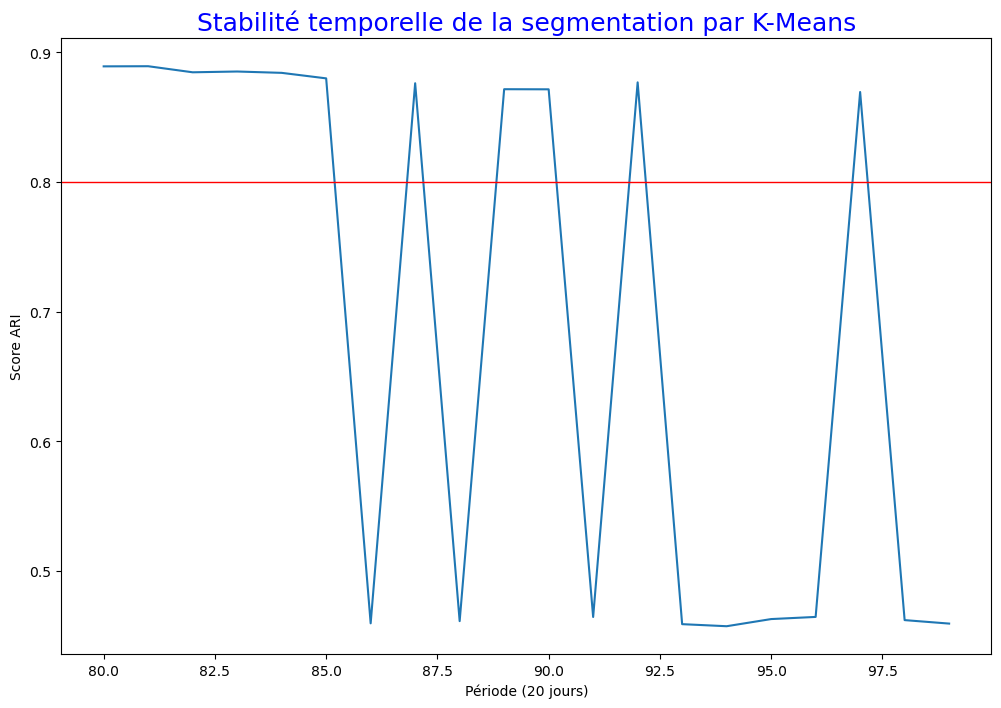

In [18]:
# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_score, x="periode", y="ARI")

plt.axhline(y=0.80, c='r', linewidth=1)

plt.xlabel("Période (20 jours)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

Pour conclure, on remarque que l'ARI Score reste stable jusqu'au 85ème jour puis devient très instable. Le clustering devra donc être mise à jour au maximum tout les 85 jours afin qu'il reste cohérent et stable. 